In [ ]:
#@title
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
#@title
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
# Load your data and print 2-3 examples
df_train[1:4]

,textID,text,selected_text,sentiment
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative


In [ ]:
#@title
# POS 
# Remove blank tweets 
df_train = df_train.drop(df_train[df_train.isnull().any(axis=1)].index)
df_test = df_test.drop(df_test[df_test.isnull().any(axis=1)].index)

# Pre-processing 
data=df_train[['text','sentiment']].copy()
data_test=df_test[['text','sentiment']].copy()
preprocess = pd.DataFrame()
preprocess['step'] = ['original text','lower case', 'remove stopword', 'remove punctuations, numbers, URLs']
preprocess['example 1'] = [data['text'][17], np.nan, np.nan, np.nan]
preprocess['example 2'] = [data['text'][20], np.nan, np.nan, np.nan]
preprocess['example 3'] = [data['text'][24], np.nan, np.nan, np.nan]
## lower cases 
data['text'] = data['text'].str.lower()
data_test['text'] = data_test['text'].str.lower()
preprocess['example 1'][1] = data['text'][17]
preprocess['example 2'][1] = data['text'][20]
preprocess['example 3'][1] = data['text'][24]

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)       #advanced substitude
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
#data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'] = data.text.replace(r'\s+', ' ', regex=True)

data_test['text'] = data_test['text'].apply(lambda x: cleaning_URLs(x))
#data_test['text'] = data_test['text'].apply(lambda x: cleaning_punctuations(x))
data_test['text'] = data_test['text'].apply(lambda x: cleaning_repeating_char(x))
data_test['text'] = data_test['text'].apply(lambda x: cleaning_numbers(x))
data_test['text'] = data_test.text.replace(r'\s+', ' ', regex=True)

import spacy 
from spacy import displacy
#  Open class words are sometimes called lexical or lexically full words, 
# as they carry more 'referential' meaning than the grammatical words.
data["NOUN"] = np.nan 
data['INTJ'] = np.nan
data['VERB'] = np.nan
data['ADJ'] = np.nan
nlp = spacy.load("en_core_web_sm")
for i in range(len(data['text'])):
  noun = ""
  intj = ""
  verb = ""
  adj = ""
  doc = nlp(data['text'].iloc[i])
  for token in doc:
    if token.pos_ == "NOUN":
        noun = noun + " " + token.lemma_  
    elif token.pos_ == "INTJ":
        intj = intj + " " + token.lemma_
    elif token.pos_ == "VERB":
        verb = verb + " " + token.lemma_
    elif token.pos_ == "ADJ":
        adj = adj + " " + token.lemma_
  data['NOUN'].iloc[i] = noun
  data['INTJ'].iloc[i] = intj
  data['VERB'].iloc[i] = verb
  data['ADJ'].iloc[i] = adj

data_test["NOUN"] = np.nan 
data_test['INTJ'] = np.nan
data_test['VERB'] = np.nan
data_test['ADJ'] = np.nan
nlp = spacy.load("en_core_web_sm")
for i in range(len(data_test['text'])):
  noun = ""
  intj = ""
  verb = ""
  adj = ""
  doc = nlp(data_test['text'].iloc[i])
  for token in doc:
    if token.pos_ == "NOUN":
        noun = noun + " " + token.lemma_  
    elif token.pos_ == "INTJ":
        intj = intj + " " + token.lemma_
    elif token.pos_ == "VERB":
        verb = verb + " " + token.lemma_
    elif token.pos_ == "ADJ":
        adj = adj + " " + token.lemma_
  data_test['NOUN'].iloc[i] = noun
  data_test['INTJ'].iloc[i] = intj
  data_test['VERB'].iloc[i] = verb
  data_test['ADJ'].iloc[i] = adj


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
data.to_csv('data_POS.csv')
data_test.to_csv('data_test_POS.csv')

In [ ]:
y_train = data.sentiment
y_test = data_test.sentiment

In [ ]:
from sklearn.pipeline import make_union

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 1),
    max_features=30000)
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(1, 4),
    max_features=30000)
vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=2)
vectorizer.fit(data.NOUN)
X_train_NOUN = vectorizer.transform(data.NOUN)
X_test_NOUN = vectorizer.transform(data_test.NOUN)
vectorizer.fit(data.INTJ)
X_train_INTJ = vectorizer.transform(data.INTJ)
X_test_INTJ = vectorizer.transform(data_test.INTJ)
vectorizer.fit(data.VERB)
X_train_VERB = vectorizer.transform(data.VERB)
X_test_VERB = vectorizer.transform(data_test.VERB)
vectorizer.fit(data.ADJ)
X_train_ADJ = vectorizer.transform(data.ADJ)
X_test_ADJ = vectorizer.transform(data_test.ADJ)



In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(data.text)
X_train_text = vectoriser.transform(data.text)
X_test_text  = vectoriser.transform(data_test.text)

In [ ]:
from scipy.sparse import hstack
X_train_tfidf = hstack([X_train_NOUN,X_train_INTJ,X_train_VERB,X_train_ADJ]) #,X_train_text
X_test_tfidf = hstack([X_test_NOUN,X_test_INTJ,X_test_VERB,X_test_ADJ]) #,X_test_text

In [ ]:
X_train_tfidf

<27480x83955 sparse matrix of type '<class 'numpy.float64'>'
	with 2754380 stored elements in COOrdinate format>

In [ ]:
#@title
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### LG

Confusion matrix, without normalization
[[ 739  291   73]
 [ 176 1011  243]
 [  68  299  634]]


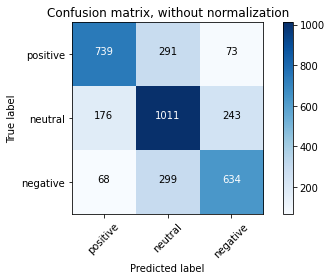

In [ ]:
LRmodel = LogisticRegression(C = 3, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train_tfidf, y_train)
y_pred3 = LRmodel.predict(X_test_tfidf)
cnf_matrix = confusion_matrix(y_test, y_pred3,labels=['positive', 'neutral', 'negative'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['positive', 'neutral', 'negative'],
                      title='Confusion matrix, without normalization')

### NB

Confusion matrix, without normalization
[[ 664  368   71]
 [ 199 1017  214]
 [  68  365  568]]


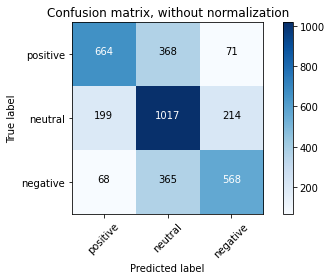

In [ ]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train_tfidf, y_train)
y_pred1 = BNBmodel.predict(X_test_tfidf)
cnf_matrix = confusion_matrix(y_test, y_pred1,labels=['positive', 'neutral', 'negative'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['positive', 'neutral', 'negative'],
                      title='Confusion matrix, without normalization')

#### SVM

In [ ]:
#@title
def model_Evaluate(model,X_test,y_test):
  # Predict values for Test dataset
  y_pred = model.predict(X_test)
  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [ ]:
data1_train = data.copy()
data1_test = data_test.copy()
data1_train['sentiment'] = data1_train['sentiment'].apply(lambda x: 'negative' if x == 'negative' else 'Pos/Neu')
data1_test['sentiment'] = data1_test['sentiment'].apply(lambda x: 'negative' if x == 'negative' else 'Pos/Neu')

data2_train = data[data.sentiment != "negative"].copy()
data2_test = data_test[data_test.sentiment != "negative"].copy()

In [ ]:
y_train = data1_train.sentiment
y_test = data1_test.sentiment

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 1),
    max_features=30000)
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(1, 4),
    max_features=30000)
vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=2)
vectorizer.fit(data1_train.NOUN)
X_train_NOUN = vectorizer.transform(data1_train.NOUN)
X_test_NOUN = vectorizer.transform(data1_test.NOUN)
vectorizer.fit(data1_train.INTJ)
X_train_INTJ = vectorizer.transform(data1_train.INTJ)
X_test_INTJ = vectorizer.transform(data1_test.INTJ)
vectorizer.fit(data1_train.VERB)
X_train_VERB = vectorizer.transform(data1_train.VERB)
X_test_VERB = vectorizer.transform(data1_test.VERB)
vectorizer.fit(data1_train.ADJ)
X_train_ADJ = vectorizer.transform(data1_train.ADJ)
X_test_ADJ = vectorizer.transform(data1_test.ADJ)

vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(data1_train.text)
X_train_text = vectoriser.transform(data1_train.text)
X_test_text  = vectoriser.transform(data1_test.text)

from scipy.sparse import hstack
X_train_tfidf = hstack([X_train_NOUN,X_train_INTJ,X_train_VERB,X_train_ADJ,X_train_text])
X_test_tfidf = hstack([X_test_NOUN,X_test_INTJ,X_test_VERB,X_test_ADJ,X_test_text])

              precision    recall  f1-score   support

     Pos/Neu       0.87      0.89      0.88      2533
    negative       0.71      0.65      0.68      1001

    accuracy                           0.83      3534
   macro avg       0.79      0.77      0.78      3534
weighted avg       0.82      0.83      0.82      3534



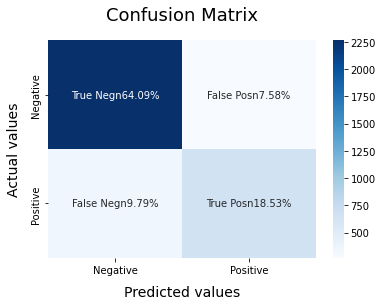

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train_tfidf, y_train)
model_Evaluate(SVCmodel,X_test_tfidf,y_test)
y_pred2 = SVCmodel.predict(X_test_tfidf)

In [ ]:
y_train = data2_train.sentiment
y_test = data2_test.sentiment

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 1),
    max_features=30000)
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(1, 4),
    max_features=30000)
vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=2)
vectorizer.fit(data2_train.NOUN)
X_train_NOUN = vectorizer.transform(data2_train.NOUN)
X_test_NOUN = vectorizer.transform(data2_test.NOUN)
vectorizer.fit(data2_train.INTJ)
X_train_INTJ = vectorizer.transform(data2_train.INTJ)
X_test_INTJ = vectorizer.transform(data2_test.INTJ)
vectorizer.fit(data2_train.VERB)
X_train_VERB = vectorizer.transform(data2_train.VERB)
X_test_VERB = vectorizer.transform(data2_test.VERB)
vectorizer.fit(data2_train.ADJ)
X_train_ADJ = vectorizer.transform(data2_train.ADJ)
X_test_ADJ = vectorizer.transform(data2_test.ADJ)

vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(data2_train.text)
X_train_text = vectoriser.transform(data2_train.text)
X_test_text  = vectoriser.transform(data2_test.text)

from scipy.sparse import hstack
X_train_tfidf = hstack([X_train_NOUN,X_train_INTJ,X_train_VERB,X_train_ADJ,X_train_text])
X_test_tfidf = hstack([X_test_NOUN,X_test_INTJ,X_test_VERB,X_test_ADJ,X_test_text])

              precision    recall  f1-score   support

     neutral       0.80      0.85      0.82      1430
    positive       0.79      0.73      0.76      1103

    accuracy                           0.80      2533
   macro avg       0.79      0.79      0.79      2533
weighted avg       0.79      0.80      0.79      2533



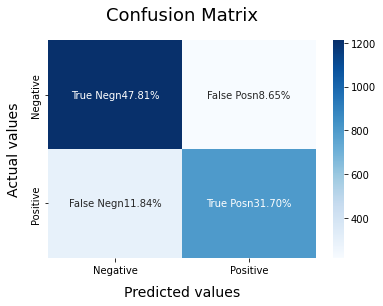

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train_tfidf, y_train)
model_Evaluate(SVCmodel,X_test_tfidf,y_test)
y_pred2 = SVCmodel.predict(X_test_tfidf)